# Data Preparation<a class="tocSkip">
## Ciencia de Datos <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**

# Regularización - Optimización - Feature Engineering - Pipelines



## Planteo del Problema
El problema que vamos a tratar de resolver es de **predecir** el **salario** de un **jugador de la NBA** de la temporada 2019-2020 en base a sus estadísticas de juego durante la temporada

Las técnicas de **regularización** son útiles para trabajar con conjuntos con **gran cantidad de variables**, las cuales pueden introducir variabilidad en las estimaciones de los parámetros.

## Conjunto de datos
Los datos provienen de la página  [Basketball Reference](https://www.basketball-reference.com/) y fueron previamente trabajados por nosotros para obtener el formato actual.

Las variables del set son:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')


In [2]:
#definimos la semilla
semilla = 42

In [3]:
#Obtenemos el nombre de las variables
### Cambiar nombre

diccionario = pd.read_excel('diccionario_terminos.xlsx')
diccionario

,variable,descripcion
0,player,nombre
1,salary,Salario
2,position,Posicion en el campo de juego
3,age,Edad
4,team_id,Nombre del Equipo
5,g,Cantidad de Partidos
6,gs,Partidos como titular
7,mp_per_g,minutos por partido
8,fg_per_g,Tiros de campo por partido (dobles y triples)
9,fga_per_g,Intentos de tiro de campo


En el glosario de [Basketball Reference](https://www.basketball-reference.com/) pueden encontrar una descripción más exhaustiva de cada una de estas métricas.

In [4]:
#Lectura del dataset

nba = pd.read_csv('nba_salarios_2021.csv')


In [5]:
# Limpiamos algunas de las variables
nba['position'] = nba['position'].str.replace('-.*','')
nba = nba.fillna(0)


In [6]:
# Observamos la informacion del dataset
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   player      403 non-null    object 
 1   salary      403 non-null    float64
 2   position    403 non-null    object 
 3   age         403 non-null    int64  
 4   team_id     403 non-null    object 
 5   g           403 non-null    int64  
 6   gs          403 non-null    int64  
 7   mp_per_g    403 non-null    float64
 8   fg_per_g    403 non-null    float64
 9   fga_per_g   403 non-null    float64
 10  fg_pct      403 non-null    float64
 11  fg3_per_g   403 non-null    float64
 12  fg3a_per_g  403 non-null    float64
 13  fg3_pct     403 non-null    float64
 14  fg2_per_g   403 non-null    float64
 15  fg2a_per_g  403 non-null    float64
 16  fg2_pct     403 non-null    float64
 17  efg_pct     403 non-null    float64
 18  ft_per_g    403 non-null    float64
 19  fta_per_g   403 non-null    f

### 1. Análsis Exploratorio


#### Gráfico de la relación entre la posición y el salario
Veamos como es la distribución de salarios según la posición de juego. Se agregan las etiquetas de los jugadores que cobran mayores sueldos **buscar forma de agregar labels no muy compleja** 

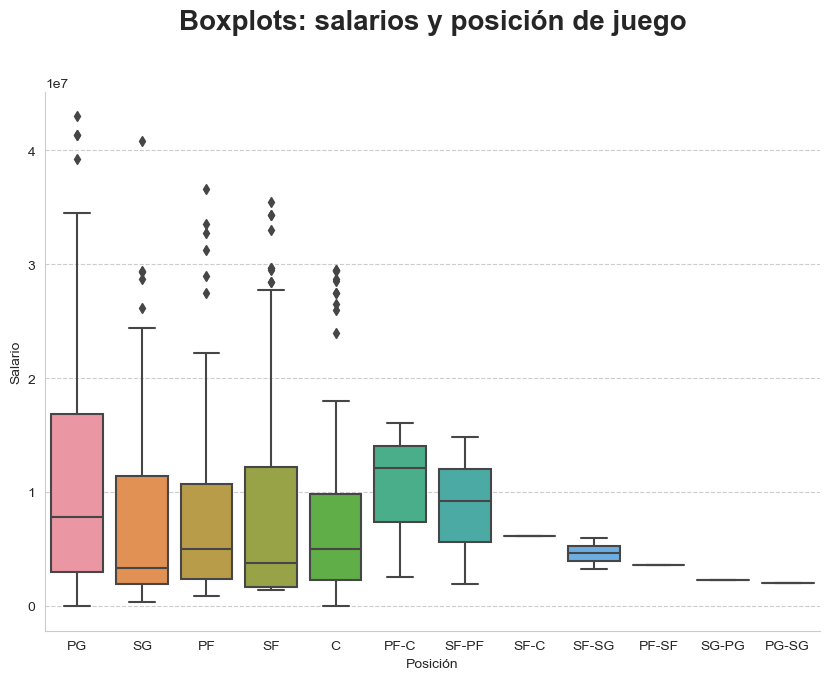

In [7]:
# Graficamos la relacion entre las posicion y el salario del jugador 

fig, ax = plt.subplots(figsize=(10,7))
ax = sns.boxplot(x="position", y="salary", data=nba)
ax.set_title('Boxplots: salarios y posición de juego', fontweight='bold', fontsize=20, y=1.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle='--')
ax.set_ylabel('Salario', fontsize=10)
ax.set_xlabel('Posición', fontsize=10)
plt.show()

Observamos que la distribucion varía un poco entre las posiciones y hay varios jugadores que son outliers.

#### Correlograma
Realizamos un correlograma entre todas las variables cuantitativas

In [8]:
# Obtenemos las variables numericas y generamos la matriz de correlacion
nba_numericas = nba.select_dtypes(include=['float64','int64'])
matriz_correlacion = nba_numericas.corr()

In [9]:
# Graficamos la correlacion entre las variables

mask = np.zeros_like(matriz_correlacion, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(17, 17))

heatmap = sns.heatmap(matriz_correlacion,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks': [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True, annot_kws={"fontsize":8})


ax.set_yticklabels(matriz_correlacion.columns, rotation = 0)
ax.set_xticklabels(matriz_correlacion.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Observamos que existen relaciones de diversa magnitud y signo entre todas las variables.

### Analisis de Distribución, Scatterplot y correlación de algunas variables

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


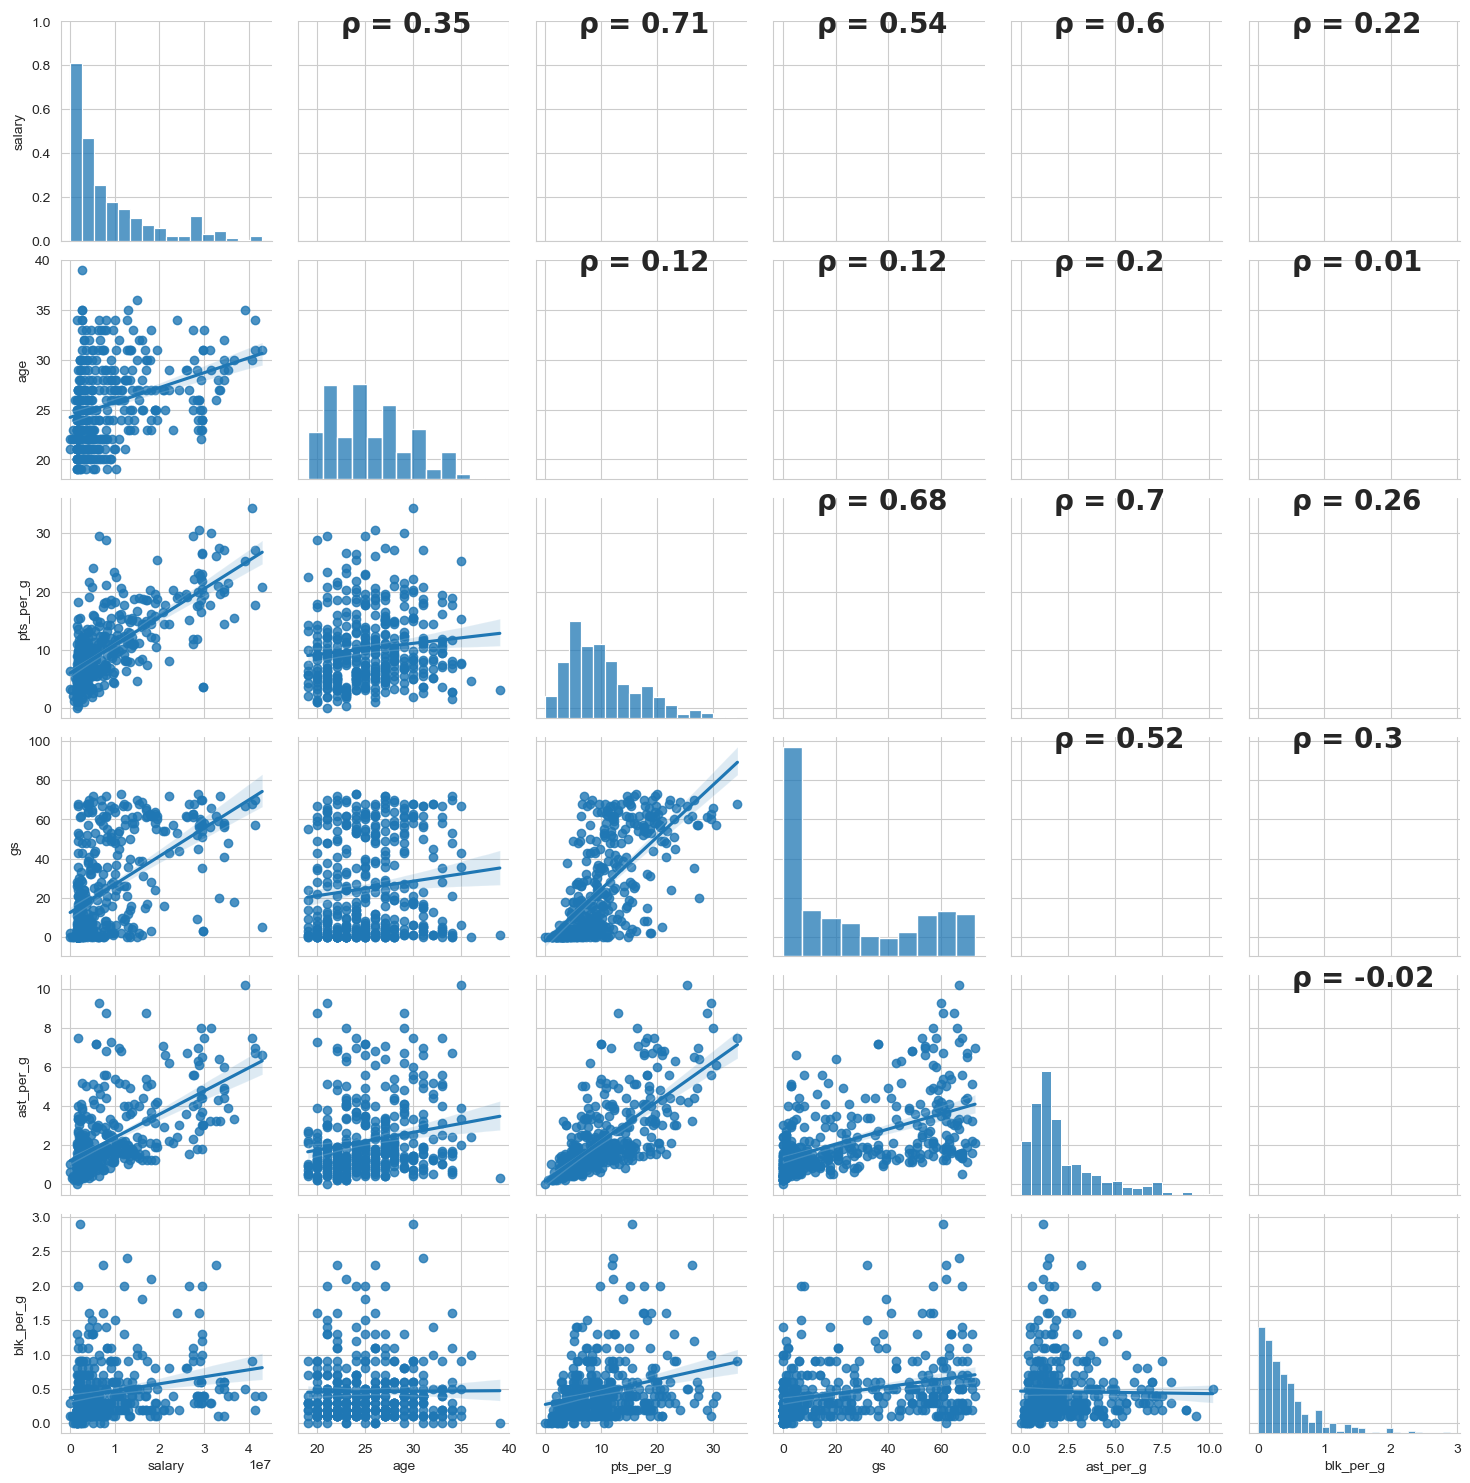

In [10]:
#Seleccionamos algunas variables y graficamos su correlacion 

nba_numericas_seleccion = nba_numericas[['salary','age','pts_per_g','gs','ast_per_g','blk_per_g']]

def corr(x, y, **kwargs):
    
    # Calculamos el valor de la correlacion
    coef = np.corrcoef(x, y)[0][1]
    # Generamos la etiqueta
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Agregamos la etiqueta al grafico
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
    

# Mapeamos los graficos en las ubicaciones correspondientes
g = sns.PairGrid(nba_numericas_seleccion)
g.map_diag(sns.histplot)
g.map_lower(sns.regplot)
g.map_upper(corr)

Se puede observar que el **salario** se correlaciona de forma positiva con todas las variables.
Tambien se puede ver una **correlacion positiva** entre los **pts_per_g** (puntos por partido) y **ast_per_g** (asistencia por partido)

## Modelo Lineal

Vamos a ajustar un modelo lineal que incluya todas las variables (excepto el nombre del jugaodr y del equipo) y obtendremos todos los parámetros del modelo junto al valor de su intervalo de confianza

$E(salario|.) = \beta_0 + \beta_1 \cdot age + \beta_2 \cdot g + ... + \beta_n \cdot position\_SG$

#### Creación de las variables dummies

Para crear las variables dummies vamos a utilizar el transformer (es un tipo de clase) [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). Los argumentos que vamos a utilizar son:

* `categories:` la lista de categorías que tiene la variable categórica
* `drop='first'`: indica que se va a "tirar" la primera categoría (es la que queda contenida en el intercepto)

### Coeficientes estimados

Creamos el modelo y accedemos a la información de los coeficientes

In [11]:
# Eliminamos las variables del nombre del jugador y el equipo
nba_lineal = nba.drop(['player','team_id'], axis = 1)

In [12]:
# Seleccionamos las variables numericas
nba_lineal_numericas = nba_lineal.select_dtypes(include=['float64','int64'])

In [13]:
# Seleccionamos las variables categoricas y las convertimos en dummies 
nba_lineal_cat = nba_lineal.select_dtypes(include=['object'])


In [14]:
nba_lineal_cat['position'].unique()

array(['PG', 'SG', 'PF', 'SF', 'C', 'PF-C', 'SF-PF', 'SF-C', 'SF-SG',
       'PF-SF', 'SG-PG', 'PG-SG'], dtype=object)

In [15]:
from sklearn.preprocessing import OneHotEncoder

In [16]:
# Definimos una instancia del transformer
one_hot_encoder = OneHotEncoder(categories=[['PG', 'SG', 'PF', 'SF', 'C']], drop='first')

In [17]:
# Realizamos el fit con los datos de entrenamiento
one_hot_encoder.fit(nba_lineal_cat[['position']])

ValueError: Found unknown categories ['SF-C', 'SF-SG', 'PG-SG', 'SG-PG', 'PF-SF', 'SF-PF', 'PF-C'] in column 0 during fit

In [18]:
# Accedemos a las categorias del encoder
one_hot_encoder.categories_

[]

In [19]:
 # Generamos las variables dummies de la variable property type (notemos que tenemos 2 columnas!)
 matriz_dummies = one_hot_encoder.transform(nba_lineal_cat[['position']]).toarray()
 matriz_dummies

IndexError: list index out of range

In [22]:
# Generamos los nombres de las variables dummies (notemos que tenemos 2 columnas!)
nombres_dummies = one_hot_encoder.get_feature_names_out(['position'])
nombres_dummies

array(['position_SG', 'position_PF', 'position_SF', 'position_C'],
      dtype=object)

In [23]:
# Generamos el dataframe con las variables dummies con las matrices y columnas
df_dummies = pd.DataFrame(matriz_dummies, columns=nombres_dummies, index=nba_lineal_cat.index)
df_dummies.head()

,position_SG,position_PF,position_SF,position_C
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [24]:
# Separamos las variables predictoras de la que va a ser preditcha 'salary'
nba_lineal = pd.concat([nba_lineal_numericas, df_dummies],axis=1)
X = nba_lineal.drop(['salary'], axis = 1)
reg_features = X.columns
y = nba_lineal['salary']


In [25]:
# Import el paquete sm de la libreria stats
import statsmodels.api as sm
from statsmodels.api import add_constant

In [26]:
# Construimos el modelo agregando una constante
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

In [27]:
# Error Cuadratico Medio de los Residuos
print(f"ECM: {results.mse_resid}")

ECM: 31832279898386.117


In [28]:
# Visualizamos el ajuste final
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     24.78
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           8.41e-71
Time:                        11:23:09   Log-Likelihood:                -6820.6
No. Observations:                 403   AIC:                         1.370e+04
Df Residuals:                     372   BIC:                         1.383e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.341e+07    4.1e+06     -3.271      

In [29]:
def coef_summary(results):
    '''
    Toma los resultado del modelo de OLS 
    
    Elimina el intercepto.
    '''
    # Creo un dataframe de los resultados del summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Agrego el nombre de las columnas
    coef_df.columns = coef_df.iloc[0]

    # Elimino la fila extra del intercepto
    coef_df=coef_df.drop(0)

    # Seteo el nombre de las variables como index
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Convertimos a float los object 
    coef_df = coef_df.astype(float)

    # Obtenemos el error; (coef - limite inferior del IC)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Agregamos los errores al dataframe
    coef_df['errors'] = errors

    # Eliminamos la variable const
    coef_df = coef_df.drop(['const'])

    # Ordenamos los coeficientes 
    coef_df = coef_df.sort_values(by=['coef'])

    ### Graficamos ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Agregamos la columna con el nombre de las variables
    coef_df['variables'] = variables
   
    return  coef_df

In [30]:
# Aplicamos la funcion coef_summary a los results

coef_df = coef_summary(results)

Graficamos los p-valores de mayor a menor para evaluar la significatividad individual de los coeficientes

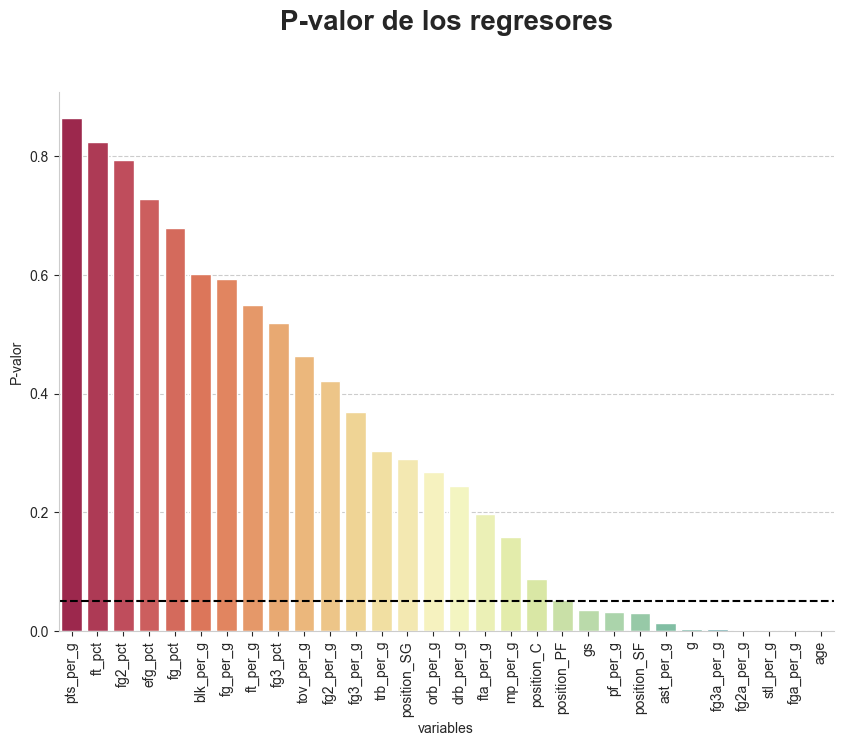

In [31]:
# Graficamos los p-valor
fig, ax = plt.subplots(figsize=(10,7))
coef_df = coef_df.sort_values(by='P>|t|', ascending = False)
ax = sns.barplot(x='variables', y='P>|t|', data=coef_df,
                 palette="Spectral")
ax.set_title('P-valor de los regresores', fontweight='bold', fontsize=20, y=1.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle='--')
ax.set_ylabel('P-valor', fontsize=10)
ax.set_xlabel('variables', fontsize=10)
plt.xticks(rotation=90, fontsize = 10 )
plt.yticks( fontsize = 10 )
plt.axhline(y = 0.05, color = 'black', linestyle = '--')
plt.show()

Notamos que:

* Solo algunas variables tienen coeficientes significativos: **gs**,  **pf_per_g**, **ast_per_g**, **g**, **position_SG**, **fg3a_per_g**, **fg2a_per_g**, **fga_per_g**, **position_PG**, **stl_per_g**, **age**

Para evitar los problemas que puede introducir la escala, reescalamos las variables y repetimos el ajuste para estos nuevos datos


In [32]:
#Importamos StandardScaler de la libreria sklear
from sklearn.preprocessing import StandardScaler

In [33]:
# Instanciamos la funcion para escalar
scaler = StandardScaler()

In [34]:
# Seleccionamos las variables numericas
nba_lineal = nba.drop(['player','team_id'], axis = 1)
nba_lineal_numericas = nba_lineal.select_dtypes(include=['float64','int64'])
# Eliminamos la variable salary del escalado
nba_lineal_numericas= nba_lineal_numericas.drop(['salary'], axis = 1)
nba_lineal_numericas_columns = nba_lineal_numericas.columns

In [35]:
#Escalamos las variables
scaled = scaler.fit_transform(nba_lineal_numericas)

In [36]:
# Generamos un dataframe con las variables escaladas
nba_lineal_numericas = pd.DataFrame(scaled, columns = nba_lineal_numericas_columns)

In [37]:
# Generamos dummies con las variables categoricas 
nba_lineal_cat = nba_lineal.select_dtypes(include=['object'])
nba_lineal_cat = pd.get_dummies(nba_lineal_cat)


In [38]:
# Generamos el conjunto de datos para ajustar el modelo
nba_lineal = pd.concat([nba_lineal_numericas, df_dummies],axis=1)                   
X = nba_lineal.copy()
y = nba['salary']

In [39]:
# Construimos el modelo agregando una constante
X = sm.add_constant(X)
model_scaled = sm.OLS(y,X)
results_scaled = model_scaled.fit()

In [40]:
# Error Cuadratico Medio de los Residuos
print(f"ECM: {results_scaled.mse_resid}")

ECM: 31832279898386.11


In [41]:
# Visualizamos el ajuste final
print(results_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     24.78
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           8.41e-71
Time:                        11:23:57   Log-Likelihood:                -6820.6
No. Observations:                 403   AIC:                         1.370e+04
Df Residuals:                     372   BIC:                         1.383e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.904e+06   1.01e+06      6.862      

In [42]:
#Graficamos los coeficientes al 95% de confianza
coef_df_scaled = coef_summary(results_scaled)

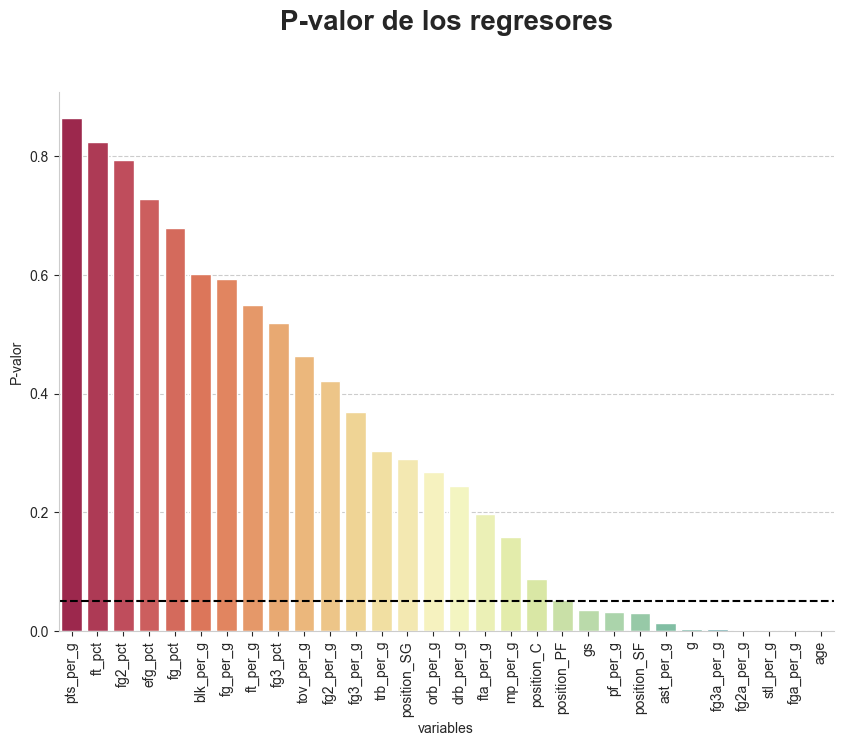

In [43]:
# Graficamos los p-valor
fig, ax = plt.subplots(figsize=(10,7))
coef_df_scaled = coef_df_scaled.sort_values(by='P>|t|', ascending = False)
ax = sns.barplot(x='variables', y='P>|t|', data=coef_df_scaled,
                 palette="Spectral")
ax.set_title('P-valor de los regresores', fontweight='bold', fontsize=20, y=1.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle='--')
ax.set_ylabel('P-valor', fontsize=10)
ax.set_xlabel('variables', fontsize=10)
plt.xticks(rotation=90, fontsize = 10 )
plt.yticks( fontsize = 10 )
plt.axhline(y = 0.05, color = 'black', linestyle = '--')
plt.show()

In [44]:
print(f"MSE Scaled: {results_scaled.rsquared}",'vs.',f"MSE: {results.rsquared}" )
print(f"Adj MSE Scaled: {results_scaled.rsquared_adj}",'vs.',f" Adj MSE: {results.rsquared_adj}" )
print(f"p-value Scaled: {results_scaled.f_pvalue}",'vs.',f" p-value: {results.f_pvalue}" )

MSE Scaled: 0.6664671283621361 vs. MSE: 0.666467128362136
Adj MSE Scaled: 0.6395693161332761 vs.  Adj MSE: 0.639569316133276
p-value Scaled: 8.4145224066738e-71 vs.  p-value: 8.414522406674517e-71


La alta cantidad de variables y la existencia de una alta correlación entre varias de ellas ocasionan que los coeficientes estimados tengan alta varianza y que muchos de ellos no sean significativos en términos estadísticos. Las técnicas de **regularización** pueden ayudarnos a mejorar esta situación.

##3. Regularización

La librería scikit-learn (sklearn) nos permite trabajar con modelos Ridge, Lasso y Elastic Net. Para cada uno de ellas tendremos una función particular para poder llevar adelante el cálculo

**Fórmula**

*ECM* + $\lambda$ [ $\alpha$ $\Sigma_{j}$|$\beta_{j}$| + (1-$\alpha$) $\Sigma_{j}$$\beta_{j}^{2}$]

$\lambda$ controla toda la penalidad, mientras que $\alpha$ controla la penalidad de la **Elastic Net** y actua como un puente entre **Lasso** y **Ridge**

Con el parámentro $\alpha$ indicamos con qué tipo de modelo deseamos trabajar:
* Ridge: $\alpha$ = 0
* Lasso: $\alpha$ = 1
*Elastic Net: 0 < $\alpha$ < 1

### 3.1 Partición Train y Test
Realizamos una partición entre dataset de entrenamiento y de testeo con la función *train_test_split* de la librería *sklearn*

In [45]:
# Importamos la funcion trai_test_split
from sklearn.model_selection import train_test_split

In [46]:
# Preparamos el conjunto de datos

nba_reg = nba.drop(['player','team_id'], axis = 1)
nba_reg_numericas = nba_reg.select_dtypes(include=['float64','int64'])
nba_reg_numericas_columns = nba_reg_numericas.columns

nba_reg_object = df_dummies.copy()
nba_reg = pd.concat([nba_reg_numericas, nba_reg_object],axis=1)
                       
X = nba_reg.drop(['salary'], axis = 1)
y = nba_reg['salary']

### 3.2 Lasso
Es un tipo de regularización la cual utiliza la penalización lineal mediante el valor absoluto. La magnitud de la penalización viene dada por el parámetro $\lambda$. Si lo pensamos mediante la formula de *ElasticNet* estariamos utilizando un $\alpha$ = 1. Para esto vamos a utilizar la función [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) de sklearn

$\hat{\beta_L}= arg min_\beta\sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=p}^{n}\beta_jx_{ji})^{2}+\lambda\sum_{j=p}^{n}|\beta_j|$

1. Cuál es la penalización que introduce el modelo Lasso?
1. Cómo impacta esto en las variables?

In [47]:
# Separamos el conjunto de datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=semilla)

In [48]:
# Importamos la funcion Lasso
from sklearn.linear_model import Lasso

Vamos a ver como se van modificando las variables para distintos valores de $\lambda$ para eso vamos a establecer a generar un número de $\lambda$ y luego lo vamos a graficar

In [49]:
# generamos 50 lambdas para evaluar los distintos escenarios
n_alphas = 50
alphas = np.logspace(-5, 7.2, n_alphas)

In [50]:
# Ajustamos  la regresion Lasso para los disntos valores de lambda que establecimos
coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

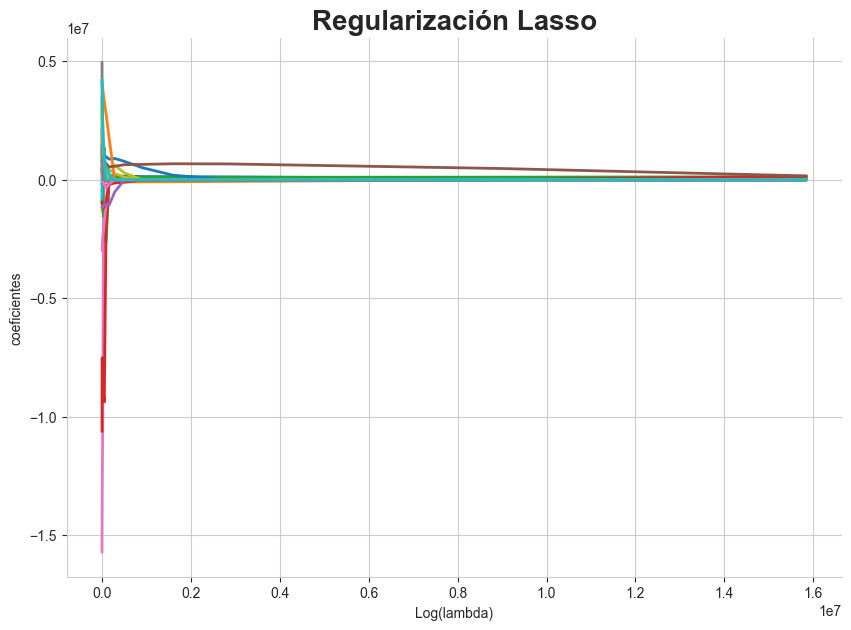

In [51]:
#Graficamos como varian las variables cuando se aumenta el lambda

fig, ax = plt.subplots(figsize=(10,7))

l1 = plt.plot(alphas, coefs,linewidth=2 )

ax.set_title('Regularización Lasso', fontweight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('coeficientes', fontsize=10)
ax.set_xlabel('Log(lambda)', fontsize=10)

plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )

plt.show()

Como la regularización *Lasso* tambien puede ser utilizada como selector de variables, vamos a quedarnos con aquellas variables que sobreviven al proceso final de selección.

In [52]:
# Nos quedamos con las variables que sobreviven al proceso de selección
coeficientes = pd.DataFrame(coefs, columns =X_train.columns)

variables_importantes = coeficientes.loc[:,X_train.columns[coeficientes.loc[45:].any().values]]

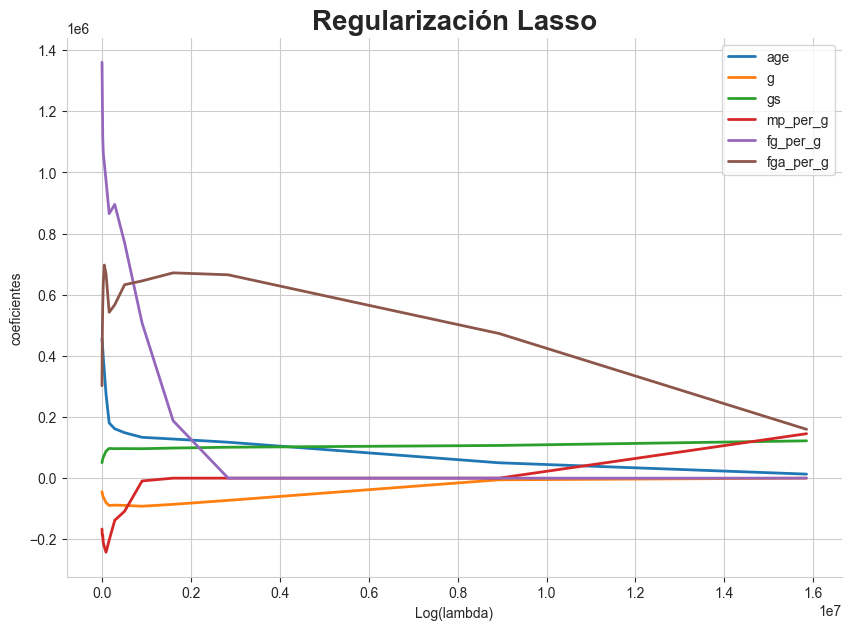

In [53]:
# Graficamos nuevamente
fig, ax = plt.subplots(figsize=(10,7))

l1 = plt.plot(alphas, variables_importantes,linewidth=2 )

ax.set_title('Regularización Lasso', fontweight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(coeficientes.columns, fontsize=10)
ax.set_ylabel('coeficientes', fontsize=10)
ax.set_xlabel('Log(lambda)', fontsize=10)

plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )

plt.show()

Los métods de regularización no son invariante a la magnitud de los datos. Por este movito es importante standarizar las variables

In [54]:
# Instanciamos la funcion para escalar
scaler = StandardScaler()

In [55]:
# Seleccionamos las variables numericas que vamos a escalar
nba_reg = nba.drop(['player','team_id'], axis = 1)
nba_reg_numericas = nba_reg.select_dtypes(include=['float64','int64'])
nba_reg_numericas_columns = nba_reg_numericas.columns

In [56]:
# Escalamos las variables
scaled = scaler.fit_transform(nba_reg_numericas)
nba_reg_numericas = pd.DataFrame(scaled, columns = nba_reg_numericas_columns)

In [57]:
# Conformamos el nuevo conjunto de entrenamiento
nba_reg = pd.concat([nba_reg_numericas, df_dummies],axis=1)
                       
X = nba_reg.drop(['salary'], axis = 1)
y = nba_reg['salary']


In [58]:
#Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=semilla)

In [59]:
# Ajsutamos nuevamente las distintas regresiones Lasso para los alphas planteados
n_alphas = 50
alphas = np.logspace(-5, 0, n_alphas)

coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

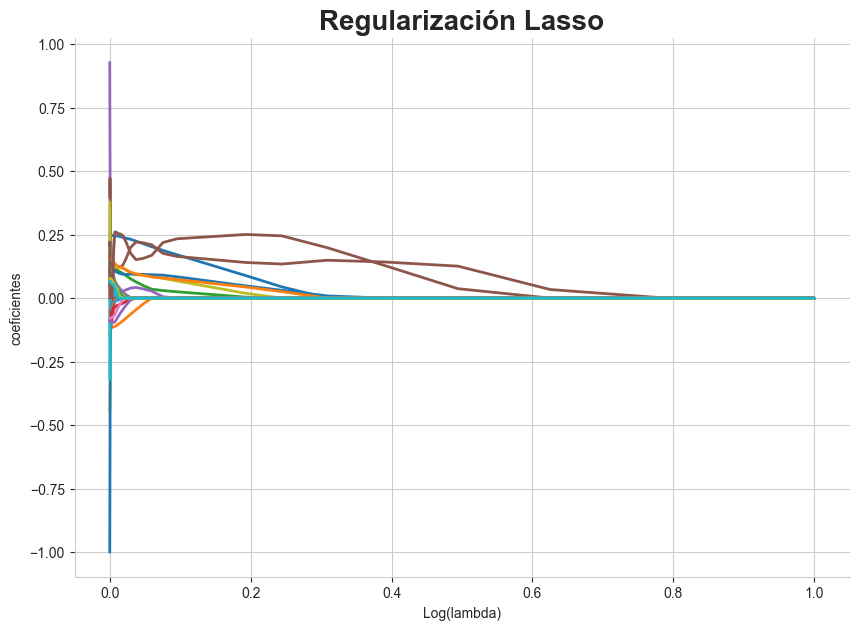

In [60]:
# Graficamos los resultados

fig, ax = plt.subplots(figsize=(10,7))

l1 = plt.plot(alphas, coefs,linewidth=2 )

ax.set_title('Regularización Lasso', fontweight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('coeficientes', fontsize=10)
ax.set_xlabel('Log(lambda)', fontsize=10)

plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )

plt.show()

Nuevamente seleccionamos aquellas variables que sobreviven al proceso de selección,

In [61]:
#Seleccionamos las variables que sobreviven mayor tiempo al proceso de seleccion
coeficientes = pd.DataFrame(coefs, columns =X_train.columns)

variables_importantes = coeficientes.loc[:,X_train.columns[coeficientes.loc[40:].any().values]]


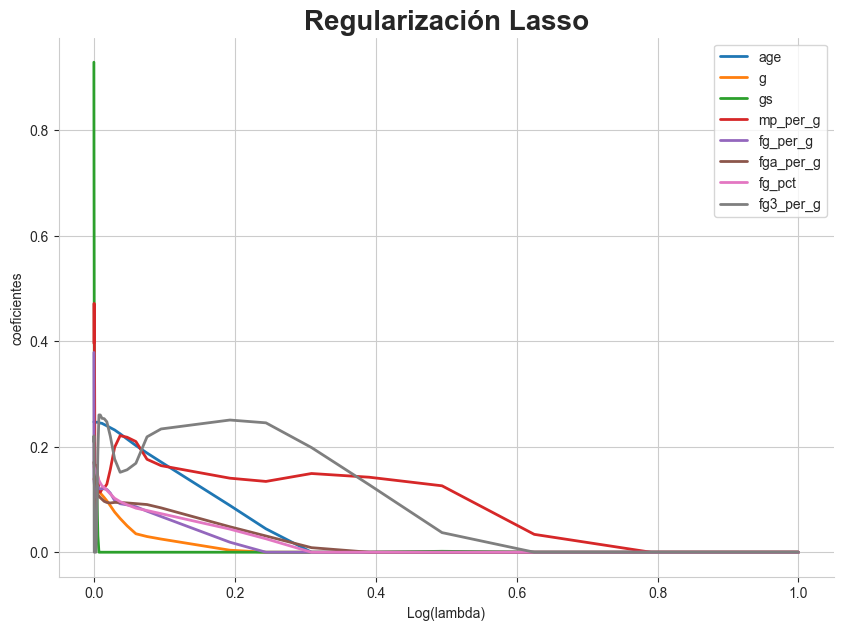

In [62]:
# Graficamos
fig, ax = plt.subplots(figsize=(10,7))

l1 = plt.plot(alphas, variables_importantes,linewidth=2 )

ax.set_title('Regularización Lasso', fontweight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(coeficientes.columns, fontsize=10)
ax.set_ylabel('coeficientes', fontsize=10)
ax.set_xlabel('Log(lambda)', fontsize=10)

plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )

plt.show()

Una de las formas de obtener un $\lambda$ optimo es utiliznado la técnica de **Cross-Validation**. 

Esta técnica consiste en partir en k partes el dataset de entrenamiento. El modelo se entrena con k-1 conjuntos y se evalua con el que fue dejado fuera. Este proceso se realiza k veces (folds) y el resultado final es el promedio de todos los entrenamientos.

En este caso ajustaremos 20 veces el modelo Lasso utilizando la función [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html?highlight=lassocv#sklearn.linear_model.LassoCV) y graficaremos la evolución del Error Cuadrático Medio para los distintos valores de $\lambda$

In [63]:
# Importamos Lasso CV
from sklearn.linear_model import LassoCV

In [64]:
# Ajustamos el modelo mediante Cross-Validation
t1 = time.time()
lasso = LassoCV(cv=20).fit(X_train, y_train)
t_lasso_cv = time.time() - t1

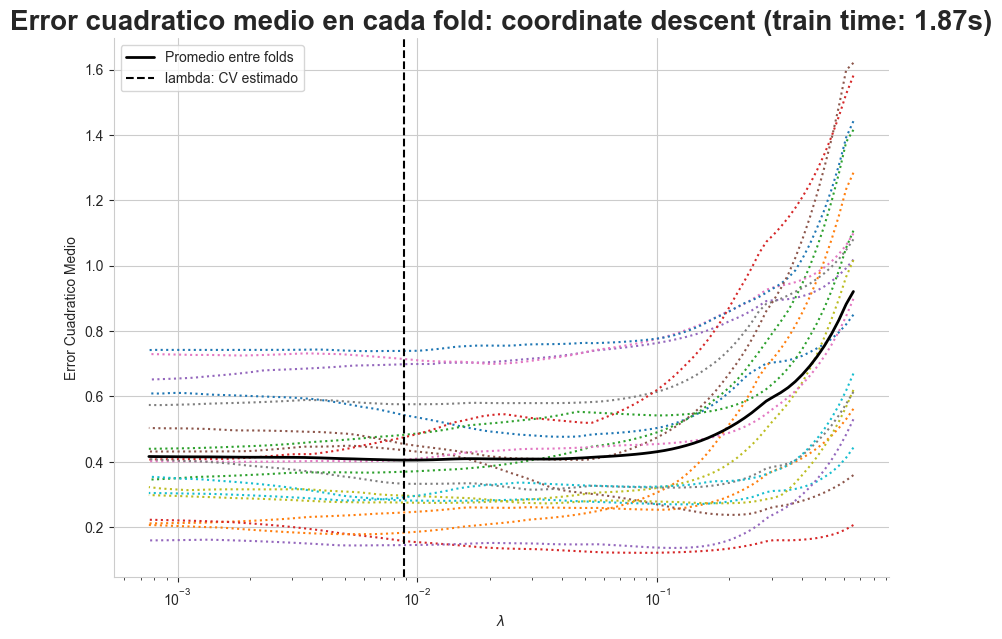

In [65]:
# Graficamos

EPSILON = 1e-4

fig, ax =plt.subplots(figsize=(10,7))
plt.semilogx(lasso.alphas_ + EPSILON, lasso.mse_path_, ':')
l1 =plt.plot(lasso.alphas_ + EPSILON, lasso.mse_path_.mean(axis=-1), 'k',
         label='Promedio entre folds', linewidth=2)
ax.axvline(lasso.alpha_ + EPSILON, linestyle='--', color='k',
            label='lambda: CV estimado')

ax.legend(fontsize=10)

ax.set_xlabel(r'$\lambda$', fontsize=10)
ax.set_ylabel('Error Cuadratico Medio', fontsize=10)
ax.set_title('Error cuadratico medio en cada fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv, fontweight='bold', fontsize=20)
plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [66]:
print(f"El lambda final obtenido mediante CV es: {lasso.alpha_}" )

El lambda final obtenido mediante CV es: 0.008701498775874544


Visualizamos los nuevos coeficientes luego de la regularización

In [67]:
coeficientes_finales = pd.DataFrame([np.array(X_train.columns.tolist()),lasso.coef_]).T
coeficientes_finales.columns = ['feature','coeficiente']
coeficientes_finales

,feature,coeficiente
0,age,0.243134
1,g,-0.102507
2,gs,0.108016
3,mp_per_g,-0.0
4,fg_per_g,0.0
5,fga_per_g,0.098043
6,fg_pct,-0.0
7,fg3_per_g,0.05894
8,fg3a_per_g,0.0
9,fg3_pct,-0.004961


In [68]:
print(f"El modelo final cuenta con : {coeficientes_finales[coeficientes_finales['coeficiente']!=0].shape[0]}",' features' )

El modelo final cuenta con : 16  features


### 3.3 Ridge

Es una técnica de regularización que utiliza una penalización cuadrática:

$\hat{\beta_L}= arg min_\beta\sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=p}^{n}\beta_jx_{ji})^{2}+\lambda\sum_{j=p}^{n}\beta_j^{2}$

Pensandolo en términos de *ElasticNet* estaríamos en el caso de $\alpha$=0. Para hacer este ajuste utilizarmos la función [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html?highlight=ridge#sklearn.linear_model.Ridge). Vamos a replicar lo que ya realizamos con Lasso

In [69]:
#Importamos el modelo
from sklearn.linear_model import Ridge

In [70]:
# Ajustamos el modelo para distintos valores de lambda
n_alphas = 30
alphas = np.logspace(-5,0, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

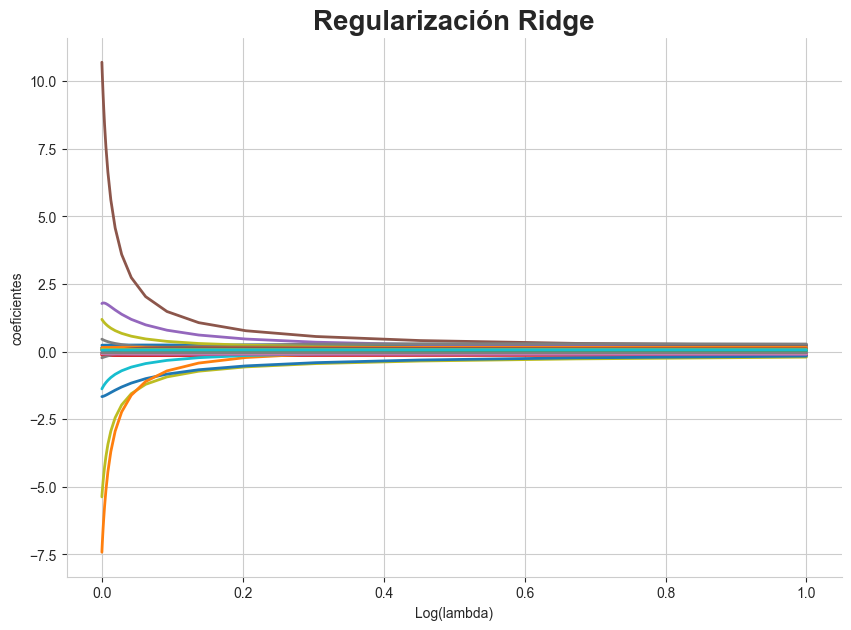

In [71]:
# Graficamos

fig, ax = plt.subplots(figsize=(10,7))

l1 = plt.plot(alphas, coefs,linewidth=2 )

ax.set_title('Regularización Ridge', fontweight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('coeficientes', fontsize=10)
ax.set_xlabel('Log(lambda)', fontsize=10)

plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )

plt.show()

Vamos a utilizar la función [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html?highlight=ridgecv#sklearn.linear_model.RidgeCV) de la librería *sklearn* para mediante Cross-Validation obtener el $\lambda$ óptimo

In [72]:
#Importamos el modelo
from sklearn.linear_model import RidgeCV

In [73]:
# Ajustamos el modelo para 100 valores distintos de lambda
n_alphas = 100
alphas = np.logspace(1,5, n_alphas)
ridge = RidgeCV(alphas=alphas, store_cv_values=True).fit(X_train, y_train)

Si queremos almacenar la evolución del ECM en RidgeCV debemos pasar el parámetro *store_cv_values=True*. Haciendo esto no podemos controlar el *k* del cv. Para poder visualizar mejor vamos a seleccionar 20 particiones aleatorias del total que realizo RidgCV

In [74]:
#La funcion RidgeCV no permite controlar la cantidad de k seleccionamos 20 al azar 
number_of_rows = ridge.cv_values_.shape[0]
random_indices = np.random.choice(number_of_rows, 
                                  size=20, 
                                  replace=False)
row = ridge.cv_values_[random_indices, :]

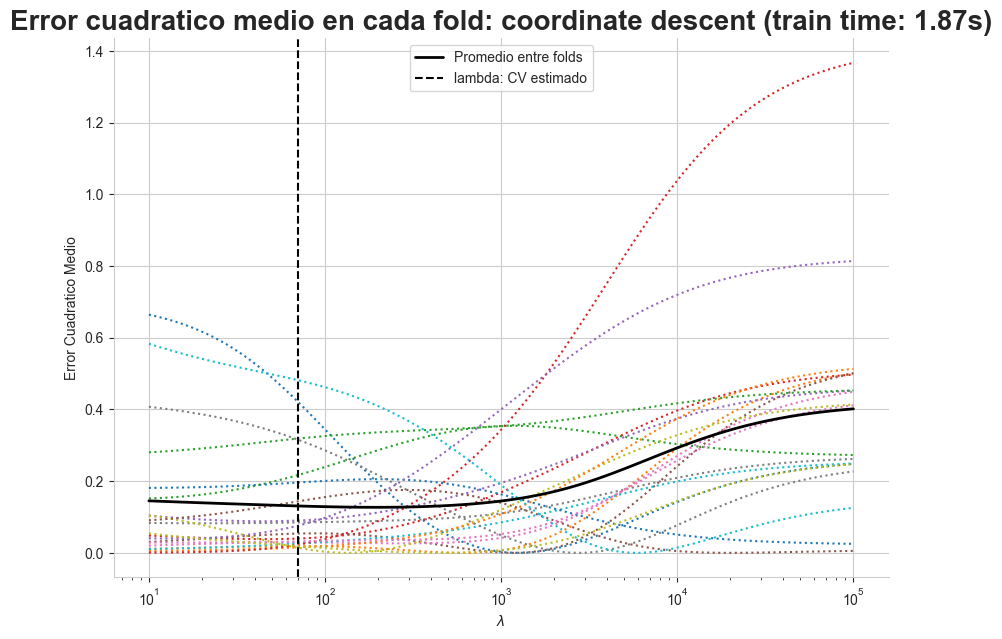

In [75]:
# Graficamos
fig, ax =plt.subplots(figsize=(10,7))

plt.semilogx(ridge.alphas + EPSILON, row.T, ':')
l1 =plt.plot(ridge.alphas + EPSILON,row.T.mean(axis=-1), 'k',
         label='Promedio entre folds', linewidth=2)
ax.axvline(ridge.alpha_ + EPSILON, linestyle='--', color='k',
            label='lambda: CV estimado')

ax.legend(fontsize=10)

ax.set_xlabel(r'$\lambda$', fontsize=10)
ax.set_ylabel('Error Cuadratico Medio', fontsize=10)
ax.set_title('Error cuadratico medio en cada fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv, fontweight='bold', fontsize=20)
plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Seleccion del Lambda optimo

In [76]:
print(f"El lambda final obtenido mediante CV es: {ridge.alpha_}" )

El lambda final obtenido mediante CV es: 70.54802310718645


Visualizamos los nuevos coeficientes luego de la regularización

In [77]:
coeficientes_finales = pd.DataFrame([np.array(X_train.columns.tolist()),ridge.coef_]).T
coeficientes_finales.columns = ['feature','coeficiente']
coeficientes_finales

,feature,coeficiente
0,age,0.203966
1,g,-0.073902
2,gs,0.086728
3,mp_per_g,0.003719
4,fg_per_g,0.064339
5,fga_per_g,0.065446
6,fg_pct,-0.028061
7,fg3_per_g,0.073317
8,fg3a_per_g,0.053042
9,fg3_pct,-0.009418


### 3.4 Elastic Net

El modelo de Elastic Net incopora los dos tipos de penalización: Lasso (Norma L1) y Ridge (Norma L2). Define un compromiso entre las penalidades de lasso y ridge. El parámetro $\alpha$ regula la importancia de cada penalización, cuanto más cerca de cero será más importante la penalización del tipo Ridge y más cerca de 1, la del tipo Lasso. 

*ECM* + $\lambda$ [ $\alpha$ $\Sigma_{j}$|$\beta_{j}$| + (1-$\alpha$) $\Sigma_{j}$$\beta_{j}^{2}$]


En este caso aplicaremos un modelo con un $\alpha$=0.5. Para poder visualizar la evolución de las variables en función de $\lambda$ vamos a utilizar la funcion [enet_path](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.enet_path.html?highlight=enet_path#sklearn.linear_model.enet_path)

In [78]:
#Importamos la funcion enet_path
from sklearn.linear_model import enet_path

In [80]:
#Ajsutamos el modelo
eps = 5e-3
alphas_enet, coefs_enet, _ = enet_path(X_train, y_train, eps=eps, l1_ratio=0.5)

In [81]:
#Definimos todos los colores que vamos a utilizar para poder graficar
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
np.random.shuffle(sorted_names)

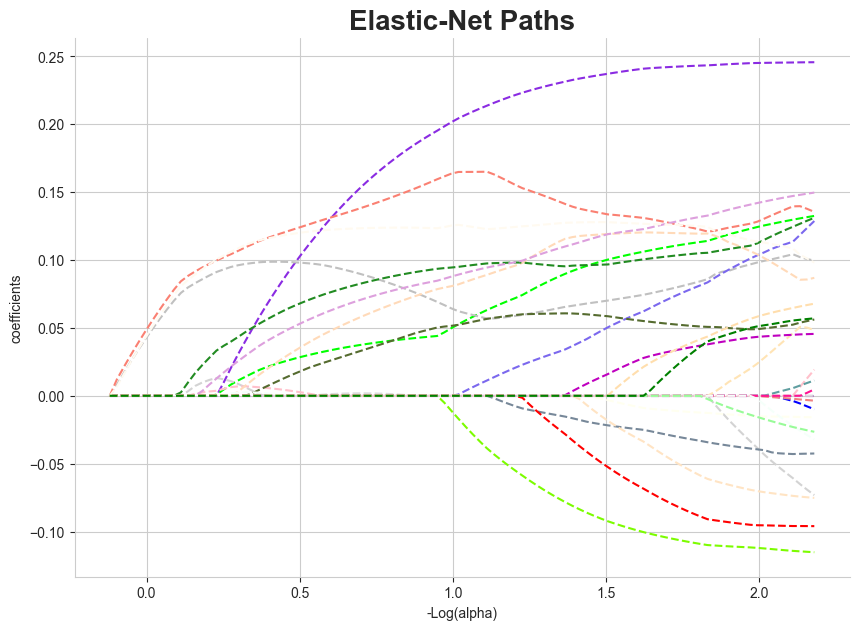

In [82]:
#Graficamos
eps = 5e-3
fig, ax =plt.subplots(figsize=(10,7))
colors = cycle(sorted_names[:30])

neg_log_alphas_enet = -np.log10(alphas_enet)
for  coef_e, c in zip(coefs_enet, colors):
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

ax.set_xlabel('-Log(alpha)',fontsize = 10)
ax.set_ylabel('coefficients',fontsize = 10)
ax.set_title('Elastic-Net Paths', fontweight='bold', fontsize=20)

plt.axis('tight')

plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Para la obtención del $\lambda$ óptimo vamos a utilizar nuevamente la estrategia de **Cross-Validation**. Para eso utilizaremos la función [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html?highlight=elasticnetcv#sklearn.linear_model.ElasticNetCV)

In [83]:
#Importamos el modelo
from sklearn.linear_model import ElasticNetCV

In [84]:
#Ajustamos el modelo
enet = ElasticNetCV(cv=20).fit(X_train, y_train)


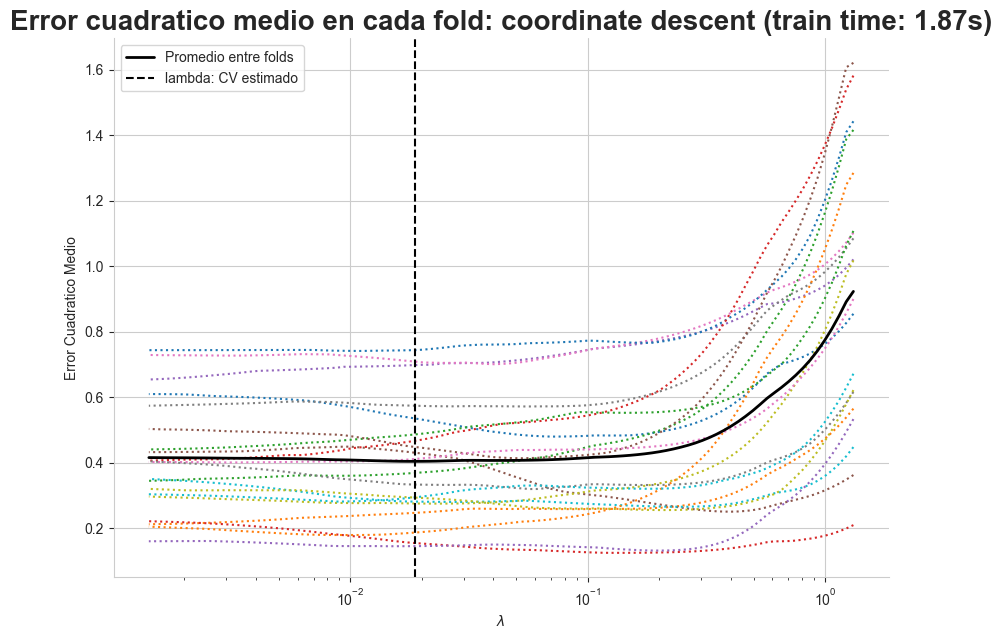

In [85]:
#Graficamos
EPSILON = 1e-4


fig, ax =plt.subplots(figsize=(10,7))
plt.semilogx(enet.alphas_ + EPSILON, enet.mse_path_, ':')
l1 =plt.plot(enet.alphas_ + EPSILON, enet.mse_path_.mean(axis=-1), 'k',
         label='Promedio entre folds', linewidth=2)
ax.axvline(enet.alpha_ + EPSILON, linestyle='--', color='k',
            label='lambda: CV estimado')

ax.legend(fontsize=10)

ax.set_xlabel(r'$\lambda$', fontsize=10)
ax.set_ylabel('Error Cuadratico Medio', fontsize=10)
ax.set_title('Error cuadratico medio en cada fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv, fontweight='bold', fontsize=20)
plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Obtenemos el lambda óptimo

In [86]:
print(f"El lambda final obtenido mediante CV es: {enet.alpha_}" )

El lambda final obtenido mediante CV es: 0.018660663839466452


Visualizamos los nuevos coeficientes luego de la regularización

In [87]:
coeficientes_finales = pd.DataFrame([np.array(X_train.columns.tolist()),enet.coef_]).T
coeficientes_finales.columns = ['feature','coeficiente']
coeficientes_finales

,feature,coeficiente
0,age,0.241194
1,g,-0.09991
2,gs,0.106392
3,mp_per_g,-0.0
4,fg_per_g,0.086682
5,fga_per_g,0.12103
6,fg_pct,-0.0
7,fg3_per_g,0.073246
8,fg3a_per_g,0.0
9,fg3_pct,-0.005786


In [88]:
print(f"El modelo final cuenta con : {coeficientes_finales[coeficientes_finales['coeficiente']!=0].shape[0]}",' features' )

El modelo final cuenta con : 17  features


### 3.5 Comparación de Modelos

Para comparar los distintos modelos lo que vamos a hacer es realizar predicciones mediante la método *.predict()* y evaluarlas con la función [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html?highlight=mean_squared_error#sklearn.metrics.mean_squared_error)

In [89]:
#importamos la metrica
from sklearn.metrics import mean_squared_error

In [90]:
# Computamos el ECM tomando como modelo al promedio de los salarios
promedio = np.repeat(y_train.mean(), y_train.shape[0])
mse_promedio = mean_squared_error(y_train, promedio)

In [91]:
#Importamos el modelo de regresion lineal
from sklearn.linear_model import LinearRegression

#Ajustamos el modelo
model_scaled_lineal = LinearRegression()
model_scaled_lineal = model_scaled_lineal.fit(X_train, y_train)

#Obtenemoos las predicciones y el ECM del modelo de regresion lineal
y_pred_lineal = model_scaled_lineal.predict(X_train)
mse_lineal = mean_squared_error(y_train, y_pred_lineal)

In [92]:
#Obtenemos el ECM de la regresion Lasso

y_pred_lasso = lasso.predict(X_train)
mse_lasso = mean_squared_error(y_train, y_pred_lasso)

In [93]:
#Obtenemos el ECM de la regresion Ridge

y_pred_ridge = ridge.predict(X_train)
mse_ridge = mean_squared_error(y_train, y_pred_ridge)

In [94]:
#Obtenemos el ECM de ElasticNet

y_pred_enet = enet.predict(X_train)
mse_enet = mean_squared_error(y_train, y_pred_enet)


In [95]:
#Ordenamos los datos y los acomodamos en un dataframe
modelo = ['promedio', 'lineal','lasso','ridge','enet']
metrica = np.repeat('ecm', 5)
error = [mse_promedio, mse_lineal, mse_lasso, mse_ridge, mse_enet]
columns = ['modelo', 'metrica', 'valor']
data = np.array([modelo, metrica, error]).T
pd.DataFrame(data=data, columns=columns)

,modelo,metrica,valor
0,promedio,ecm,0.919395409837134
1,lineal,ecm,0.3215583780799658
2,lasso,ecm,0.3469133209921146
3,ridge,ecm,0.3561568325282262
4,enet,ecm,0.3481330201481655


Ahora vamos a evaluar los modelos en el conjunto de Test

In [96]:
# Computamos el ECM tomando como modelo al promedio de los salarios
promedio = np.repeat(y_test.mean(), y_test.shape[0])
mse_promedio = mean_squared_error(y_test, promedio)

In [97]:
#Obtenemoos las predicciones y el ECM del modelo de regresion lineal
y_pred_lineal = model_scaled_lineal.predict(X_test)
mse_lineal = mean_squared_error(y_test, y_pred_lineal)

In [98]:
#Obtenemos el ECM de la regresion Lasso
y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

In [99]:
#Obtenemos el ECM de la regresion Ridge
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)


In [100]:
#Obtenemos el ECM de ElasticNet
y_pred_enet = enet.predict(X_test)
mse_enet = mean_squared_error(y_test, y_pred_enet)

In [101]:
#Ordenamos los datos y los acomodamos en un dataframe
y_pred_enet = enet.predict(X_test)
mse_enet = mean_squared_error(y_test, y_pred_enet)

modelo = ['promedio', 'lineal','lasso','ridge','enet']
metrica = np.repeat('ecm', 5)
error = [mse_promedio, mse_lineal, mse_lasso, mse_ridge, mse_enet]
columns = ['modelo', 'metrica', 'valor']
data = np.array([modelo, metrica, error]).T
pd.DataFrame(data=data, columns=columns)

,modelo,metrica,valor
0,promedio,ecm,1.1694399867471887
1,lineal,ecm,0.42377501803268725
2,lasso,ecm,0.4099963334757127
3,ridge,ecm,0.407361527720372
4,enet,ecm,0.408768120386002


## 4. Optimización de Hiperparámetros

Los **hiperparametros** no se obtienen mediante el proceso de ajuste, sino que son definición propia del modelo por parte de quien lo esta llevando adelante. La elección de los mismos va a tener una injerencia significativa en el desempeño del modelo ya que por ejemplo pueden ayudar a prevenir el *sobreajuste* o *overfitting*

En el caso particular de los modelos que estuvimos viendo en esta sección los hiperparámetros serán:
* $\lambda$: cuantifica la magnitud de la penalización o regularización a aplicar
* $\alpha$: balancea el tipo de penalidad que vamos a aplicar. Actua como un puente entre *Ridge* ($\alpha$=0) y *Lasso* ($\alpha$=1) 



### 4.1 Búsqueda de Grilla o Grid-search

Tal como indica su nombre la Búsqueda de Grilla se lleva adelante generando una matriz con los distintos valores de los parámetros que deseamos evaluar. Esto implica que la cantidad de iteraciones vendrá dada por todas las posibles combinaciones de los valores de los parámetros que indicamos en la grilla.

En nuestro caso vamos a evaluar esta estrategia sobre el modelo *Elastic Net*. Para eso vamos a utilizar la función [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) de la librería *sklearn*.
Para conformar la grilla a evaluar debemos generar un diccionario cuyas 'keys' van a ser los nombres de los parámetros y una lista de los valores para cada uno de ellos

In [102]:
# Importamos el modelo
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import  ElasticNet

In [103]:
#Definimos la grilla
parametros = {'alpha':[0.001,0.01,0.1,1,10,100],
               'l1_ratio':[0,0.25,0.5,0.75,1]}

In [104]:
# Definimos el modelo
enet = ElasticNet() 

grid_search = GridSearchCV(estimator = enet, param_grid = parametros, cv = 20, scoring ='neg_mean_squared_error')

In [105]:
#Ajustamos el modelo
start_time = time.time()
grid_search.fit(X_train, y_train)

tiempo_grid = (time.time() - start_time)
print("Tiempo de ejecucion %s segundos ---\n" % tiempo_grid)
print('Mejor combinación de parámetros %s \n'% grid_search.best_params_)
print('Definición del Modelo %s '% grid_search.best_estimator_)

Tiempo de ejecucion 4.07756233215332 segundos ---

Mejor combinación de parámetros {'alpha': 0.1, 'l1_ratio': 0} 

Definición del Modelo ElasticNet(alpha=0.1, l1_ratio=0) 


In [106]:
#Obtenemos la combinacion total de parametros
import itertools as it

diccionario_parametros = sorted(parametros)
combinaciones = it.product(*(parametros[Name] for Name in diccionario_parametros))
combinacioes_realizadas = pd.DataFrame(combinaciones, columns=['lambda', 'alpha'])
combinacioes_realizadas

,lambda,alpha
0,0.001,0.00
1,0.001,0.25
2,0.001,0.50
3,0.001,0.75
4,0.001,1.00
5,0.010,0.00
6,0.010,0.25
7,0.010,0.50
8,0.010,0.75
9,0.010,1.00


In [107]:
print('Cantidad de combinaciones evaluadas %s '% combinacioes_realizadas.shape[0])

Cantidad de combinaciones evaluadas 30 


In [108]:
#Mostramos los coeficientes fianles
coeficientes_finales_grid = pd.DataFrame([np.array(X_train.columns.tolist()),grid_search.best_estimator_.coef_]).T
coeficientes_finales_grid.columns = ['feature','coeficiente']
coeficientes_finales_grid

,feature,coeficiente
0,age,0.229535
1,g,-0.095755
2,gs,0.10859
3,mp_per_g,-0.032267
4,fg_per_g,0.073528
5,fga_per_g,0.073874
6,fg_pct,-0.035143
7,fg3_per_g,0.096238
8,fg3a_per_g,0.048539
9,fg3_pct,-0.011766


In [109]:
print(f"El modelo final cuenta con : {coeficientes_finales_grid[coeficientes_finales_grid['coeficiente']!=0].shape[0]}",' features' )

El modelo final cuenta con : 30  features


### 4.2 Búsqueda aleatoria o Random Search

Es una estrategia de búsqueda que realiza combinaciones aleatorias de los parámetros a partir de una definición de la distribución de los mismos por parte del usuario. A diferencia de la Búsqueda de Grilla, la Búsqueda aleatoria requiere que el usuario establezca la cantidad de combinaciones que se van a realizar.

Vamos a utilizar la función [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) tambien de sklearn. Al igual que en el caso de la Búsqueda de Grilla, debemos generar un diccionario con las distribuciones de los parámetros a evaluar.

In [111]:
#Importamos el modelo y algunas funciones auxiliares
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.utils.fixes import loguniform
import scipy.stats as stats
from scipy.stats import loguniform

In [112]:
# Definimos los parametros
parametros={'l1_ratio': stats.uniform(0, 1),
              'alpha': loguniform(1e-4, 1e0)}
n_iteraciones = 15
semilla = 2021

In [113]:
#Ajustamos el modelo
start_time = time.time()


enet_random = ElasticNet()
random_search = RandomizedSearchCV(estimator = enet_random, n_iter = n_iteraciones, param_distributions = parametros,
                                   cv = 20, scoring ='neg_mean_squared_error', random_state = semilla )
random_search.fit(X_train, y_train)
tiempo_random = (time.time() - start_time)

print("Tiempo de ejecucion %s segundos ---\n" % tiempo_random)
print('Mejor combinación de parámetros %s \n'% random_search.best_params_)
print('Definición del Modelo %s \n'% random_search.best_estimator_)
print('Combinaciones Evaluadas %s '% n_iteraciones)

Tiempo de ejecucion 2.785296678543091 segundos ---

Mejor combinación de parámetros {'alpha': 0.08489851771634822, 'l1_ratio': 0.06905627482497878} 

Definición del Modelo ElasticNet(alpha=0.08489851771634822, l1_ratio=0.06905627482497878) 

Combinaciones Evaluadas 15 


In [114]:
#Visualizamos los coeficientes
coeficientes_finales_random = pd.DataFrame([np.array(X_train.columns.tolist()),random_search.best_estimator_.coef_]).T
coeficientes_finales_random.columns = ['feature','coeficiente']
coeficientes_finales_random

,feature,coeficiente
0,age,0.22965
1,g,-0.092316
2,gs,0.100706
3,mp_per_g,-0.0
4,fg_per_g,0.075055
5,fga_per_g,0.077124
6,fg_pct,-0.019215
7,fg3_per_g,0.082323
8,fg3a_per_g,0.034144
9,fg3_pct,-0.008399


In [115]:
print(f"El modelo final cuenta con : {coeficientes_finales_random[coeficientes_finales_random['coeficiente']!=0].shape[0]}",' features' )

El modelo final cuenta con : 25  features


### 4.3 Comparación de Optimizadores

In [116]:
#Computamos el ECM del Grid Search
y_pred_grid = grid_search.best_estimator_.predict(X_test)
mse_grid = mean_squared_error(y_test, y_pred_grid)

In [117]:
#Computamos el ECM del Random Search
y_pred_random = random_search.best_estimator_.predict(X_test)
mse_random = mean_squared_error(y_test, y_pred_random)

In [118]:
#Organizamos la informacion en un dataframe
estrategia = ['GridSearch', 'RandomSearch']
tiempo = [tiempo_grid, tiempo_random]
metrica = np.repeat('ecm', 2)
error = [mse_grid, mse_random]
iteraciones = [combinacioes_realizadas.shape[0], n_iteraciones ]
folds = [20,20]
n_variables = [ coeficientes_finales_grid[coeficientes_finales_grid['coeficiente']!=0].shape[0], coeficientes_finales_random[coeficientes_finales_random['coeficiente']!=0].shape[0]]
columns = ['estregia','tiempo', 'metrica', 'valor', 'combinaciones', 'folds', 'n_variables']
data = np.array([estrategia, tiempo, metrica, error, iteraciones, folds, n_variables]).T
pd.DataFrame(data=data, columns=columns)

,estregia,tiempo,metrica,valor,combinaciones,folds,n_variables
0,GridSearch,4.07756233215332,ecm,0.40028554429925567,30,20,30
1,RandomSearch,2.785296678543091,ecm,0.40661539371450967,15,20,25


## 5. Feature Engineering

Vamos a cargar nuevamente el conjutno de datos para poder operar las distintas transformaciones que deseemos.

In [119]:
nba = pd.read_csv('nba_salarios_2021.csv')

### 5.1 Imputación de datos faltantes

La imputación de datos faltantes puede hacerse mediante distitnas estrategias:

**Variables Numéricas**
* Media: completar los nulos con la media de la columna
* Mediana: completar los nulos con la mediana de la columna
* Media Condicionada: los nulos se completan con la media condicionada respecto a alguna otra columna.

**Variables Numéricas o Categóricas**
* Valor más frecuente: se completa con el valor que más veces se repite en la columna
* Valor Constante: se completa con algun valor que se desee

Para poder hacerlo vamos a utilizar la función [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)

In [120]:
#Observamos cuantos datos faltantes hay en cada columna
nba.isnull().sum()

player        0
salary        2
position      0
age           0
team_id       0
g             0
gs            0
mp_per_g      0
fg_per_g      0
fga_per_g     0
fg_pct        0
fg3_per_g     0
fg3a_per_g    0
fg3_pct       0
fg2_per_g     0
fg2a_per_g    0
fg2_pct       0
efg_pct       0
ft_per_g      0
fta_per_g     0
ft_pct        0
orb_per_g     0
drb_per_g     0
trb_per_g     0
ast_per_g     0
stl_per_g     0
blk_per_g     0
tov_per_g     0
pf_per_g      0
pts_per_g     0
dtype: int64

In [121]:
#Generamos un par de nulos en la posicion para poder imputar categoricas
nba['position'] = np.where(nba['salary'].isnull(),np.nan, nba['position'])

In [122]:
# Visualizamos los casos con faltantes
nba[nba['salary'].isnull()]

,player,salary,position,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ft_pct,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g
401,Frank Jackson,NaN,NaN,21,NOP,59,2,13.5,2.3,5.6,...,0.747,0.4,1.0,1.4,1.0,0.3,0.1,0.8,1.3,6.3
402,Chimezie Metu,NaN,NaN,22,SAS,18,0,5.8,1.3,2.3,...,0.769,0.7,1.2,1.8,0.6,0.2,0.3,0.6,0.4,3.2


In [123]:
# Importamos la funcion
from sklearn.impute import SimpleImputer

In [124]:
# Separamos las variables categoricas y nulas con faltantes para poder tener una mejor visualizacion
numericas = nba[['salary']]
categoricas = nba[['position']]


Procedemos a hacerlo con las variables numéricas

In [125]:
# Imputamos con la media
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(numericas[['salary']])
numericas['media']=imputer.transform(numericas[['salary']]) 

In [126]:
# Imputamos con la mediana
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(numericas[['salary']])
numericas['mediana']=imputer.transform(numericas[['salary']]) 

In [127]:
# Imputamos con un valor constante
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 99999)
imputer.fit(numericas[['salary']])
numericas['constante']=imputer.transform(numericas[['salary']]) 

In [128]:
# Imputamos con el valor mas frecuente
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(numericas[['salary']])
numericas['mas_frecuente']=imputer.transform(numericas[['salary']]) 

In [129]:
# Visualizamos el resultado de las distintas estraegias
numericas[numericas['salary'].isnull()]

,salary,media,mediana,constante,mas_frecuente
401,NaN,8.863481e+06,4938272.0,99999.0,1517981.0
402,NaN,8.863481e+06,4938272.0,99999.0,1517981.0


Ahora lo hacemos con las variables categoricas

In [130]:
# Imputamos con un valor constante
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 'S/D')
imputer.fit(categoricas[['position']])
categoricas['constante']=imputer.transform(categoricas[['position']]) 

In [131]:
# Imputamos con el valor mas frecuente
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(categoricas[['position']])
categoricas['mas_frecuente']=imputer.transform(categoricas[['position']]) 

In [132]:
categoricas[categoricas['position'].isnull()]

,position,constante,mas_frecuente
401,NaN,S/D,SG
402,NaN,S/D,SG


### 5.2 Binning

Es una estrategia que se utiliza para agrupar en bins  los registros en función de cierto criterio. Con esto se resigna variabilidad en las variables pero se gana robustez en el modelo general.


**Numéricas** 


Vamos a armar bins a partir del valor de los salarios para eso vamos a usar la funcion *qcut*

In [133]:
# Generamos 10 bins
nba['salario_bins'] = pd.qcut(nba['salary'], q = 10)
nba[['salary','salario_bins']]

,salary,salario_bins
0,43006362.0,"(26131111.0, 43006362.0]"
1,41358814.0,"(26131111.0, 43006362.0]"
2,41358814.0,"(26131111.0, 43006362.0]"
3,40824000.0,"(26131111.0, 43006362.0]"
4,39219565.0,"(26131111.0, 43006362.0]"
...,...,...
398,898310.0,"(339999.999, 1620564.0]"
399,744684.0,"(339999.999, 1620564.0]"
400,340000.0,"(339999.999, 1620564.0]"
401,NaN,NaN


  **Categoricas**



Vamos a reemplazar todas aquellas posiciones multiples. Para eso vamos a utilizar la funcion *np.where*

In [134]:
#Observamos lso valores que puede tomar la variable position
nba.position.value_counts()

SG       92
C        82
PF       78
SF       73
PG       64
PF-C      3
SF-PF     3
SF-SG     2
SF-C      1
PF-SF     1
SG-PG     1
PG-SG     1
Name: position, dtype: int64

In [135]:
#Reemplazamos los valores que representan multiples posiciones
nba['posicion_agrup'] = np.where(nba['position'].isin(['SG','C','PF','SF','PG']),nba['position'], 'Otro')
nba['posicion_agrup'].value_counts()

SG      92
C       82
PF      78
SF      73
PG      64
Otro    14
Name: posicion_agrup, dtype: int64

### 5.3 One-hot Encoding
Dada una variable categórica con N filas y M categorías, mediante el One-hot-encoding la variable se va a expresar como una matriz de N filas por M columnas (NxM). En donde cada columna representa una de las categorías de la variable original y están codificadas con los valores 1 y 0.

Esto lo podemos llevar adelante con la función [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=onehotenco#sklearn.preprocessing.OneHotEncoder) o la función [get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) de pandas

In [136]:
#realizamos el One-hot Encoding con get_dummies
pd.get_dummies(nba['position'])

,C,PF,PF-C,PF-SF,PG,PG-SG,SF,SF-C,SF-PF,SF-SG,SG,SG-PG
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
398,0,1,0,0,0,0,0,0,0,0,0,0
399,0,0,0,0,0,0,0,0,0,0,1,0
400,0,0,0,0,0,0,0,0,0,0,1,0
401,0,0,0,0,0,0,0,0,0,0,0,0


In [137]:
#Importamos OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

In [138]:
#Imputamos los datos faltantes porque no debe contener nans
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(nba[['position']])
nba['position']=imputer.transform(nba[['position']]) 

In [139]:
#Ajustamos el encoder 
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(nba[['position']])

OneHotEncoder(handle_unknown='ignore')

In [140]:
#Generamos las dummies
dummies = enc.transform(nba[['position']])
pd.DataFrame(dummies.toarray())

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
398,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 5.4 Agrupación

Mediante la agrupación se puede  generar nuevas variables resumiendo de la información de distintas observaciones y agrupandolas según algún criterio que surte a partir de otra/otras variables. La función que utilizaremos es [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)

In [141]:
# Calculamos la media de las variables salary y fga_per_g por posicion
nba.groupby('position').agg({'salary':'mean', 'fga_per_g' :'mean'})

,salary,fga_per_g
position,,
C,8.332535e+06,6.759756
PF,8.547970e+06,7.726923
PF-C,1.025007e+07,8.066667
PF-SF,3.623000e+06,4.600000
PG,1.241442e+07,10.750000
PG-SG,2.028594e+06,6.400000
SF,8.638060e+06,7.639726
SF-C,6.167887e+06,2.800000
SF-PF,8.695466e+06,8.333333


In [142]:
# Calculamos la media de las variables salary y fga_per_g por posicion y equipo
nba.groupby(['position','team_id']).agg({'salary':'mean', 'fga_per_g' :'mean'})

salary  fga_per_g
position team_id                         
C        ATL      1.627563e+06      3.400
         BOS      3.663619e+06      4.300
         BRK      4.385176e+06      4.075
         CHI      4.200180e+06      4.700
         CHO      6.491489e+06      6.000
...                        ...        ...
SG       TOR      8.787978e+06      8.900
         TOT      9.818643e+06      7.960
         UTA      2.767750e+06     10.800
         WAS      1.531732e+07     13.700
SG-PG    TOT      2.331593e+06     10.500

[156 rows x 2 columns]

In [143]:
# Calculamos la media, el minimo, maximo y la sumo de la variable salary
nba.groupby('position').agg(min_salary=('salary', 'min'), 
                            max_salary=('salary', 'max'),
                            media_salary = ('salary', 'mean'),
                            suma_salary = ('salary', 'sum'))

,min_salary,max_salary,media_salary,suma_salary
position,,,,
C,1445697.0,29542010.0,8.332535e+06,683267884.0
PF,898310.0,36595996.0,8.547970e+06,666741644.0
PF-C,2564753.0,16047100.0,1.025007e+07,30750198.0
PF-SF,3623000.0,3623000.0,3.623000e+06,3623000.0
PG,1000000.0,43006362.0,1.241442e+07,794522696.0
PG-SG,2028594.0,2028594.0,2.028594e+06,2028594.0
SF,1445697.0,35450412.0,8.638060e+06,630578366.0
SF-C,6167887.0,6167887.0,6.167887e+06,6167887.0
SF-PF,1944677.0,14883721.0,8.695466e+06,26086398.0


### 5.5 Escalado de Datos

Hay algoritmos que son sonsibles a la magnitud de los datos, por eso se vuelve relevalante escalarlos y llevarlos todos al mismo rango. Para existo se utilizan principalmente dos strategias

* Normalización: $X_{norm} = \frac{X-X_{min}}{X_{max}-X_{min}}$

* Estandarización: $X_{std} = \frac{X-\mu}{\sigma}$

Donde $\mu$ y $\sigma$ son la media y el desvío standard de la distribución de la variable a estandarizar.

Para la estandarizacion vamos a utilizar [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standard%20scaler#sklearn.preprocessing.StandardScaler) y para la normalización [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html?highlight=minmax#sklearn.preprocessing.MinMaxScaler) ambas de *sklearn*


In [144]:
#generamos un dataframe que sea solo la columna salario
salario = nba[['salary']]

In [145]:
# Vamos a normalizar la variable salario
# Importamos la función
from sklearn.preprocessing import MinMaxScaler

In [146]:
#Ajustamos el escalado
scaler = MinMaxScaler()
scaler.fit(salario[['salary']])

MinMaxScaler()

In [147]:
#Realizamos la normalizacion
salario['norm'] = scaler.transform(salario[['salary']])

In [148]:
salario

,salary,norm
0,43006362.0,1.000000
1,41358814.0,0.961385
2,41358814.0,0.961385
3,40824000.0,0.948851
4,39219565.0,0.911246
...,...,...
398,898310.0,0.013085
399,744684.0,0.009485
400,340000.0,0.000000
401,NaN,NaN


In [149]:
# Vamos a estandarizar la variable salario
# Importamos la función
from sklearn.preprocessing import StandardScaler

In [150]:
#Ajustamos el escalado
scaler = StandardScaler()
scaler.fit(salario[['salary']])

StandardScaler()

In [151]:
#Realizamos la estandarización
salario['std'] = scaler.transform(salario[['salary']])

In [152]:
#vemos como quedaron las distitnas alternativas
salario

,salary,norm,std
0,43006362.0,1.000000,3.636593
1,41358814.0,0.961385,3.461111
2,41358814.0,0.961385,3.461111
3,40824000.0,0.948851,3.404147
4,39219565.0,0.911246,3.233257
...,...,...,...
398,898310.0,0.013085,-0.848378
399,744684.0,0.009485,-0.864741
400,340000.0,0.000000,-0.907845
401,NaN,NaN,NaN


In [153]:
#Vemos la distribucion
salario.describe()


,salary,norm,std
count,4.010000e+02,401.000000,401.000000
mean,8.863481e+06,0.199771,0.000000
std,9.400429e+06,0.220324,1.001249
min,3.400000e+05,0.000000,-0.907845
25%,2.090040e+06,0.041017,-0.721446
50%,4.938272e+06,0.107773,-0.418078
75%,1.213834e+07,0.276526,0.348809
max,4.300636e+07,1.000000,3.636593


## 6. Pipelines

Un pipeline es *‘Una lista de transformaciones aplicadas de forma secuencial sobre el estimador. Los pasos intermedios deben ser “transforms” es decir, implementan los métodos fit y transform. El estimador final sólo necesita implementar el fit’*.

Vamos a usar la función [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) a la cual le debemos pasar una lista de tuplas de procedimientos que queremos realizar.

Trabajaremos con variables numericas para ejemplificar el procedimiento

In [154]:
#Seleccionamos las variables numéricas
nba_numericas = nba.select_dtypes(include=['float64','int64'])
nba_numericas.head()

,salary,age,g,gs,mp_per_g,fg_per_g,fga_per_g,fg_pct,fg3_per_g,fg3a_per_g,...,ft_pct,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g
0,43006362.0,31,5,5,27.8,6.6,16.4,0.402,2.4,9.8,...,1.000,0.8,4.4,5.2,6.6,1.0,0.4,3.2,2.2,20.8
1,41358814.0,31,57,57,35.9,10.6,22.5,0.472,1.0,3.7,...,0.763,1.8,6.2,7.9,7.0,1.6,0.4,4.5,3.5,27.2
2,41358814.0,34,70,70,31.5,6.2,12.7,0.489,1.6,4.3,...,0.907,0.4,4.6,5.0,6.7,1.6,0.2,2.3,2.3,17.6
3,40824000.0,30,68,68,36.5,9.9,22.3,0.444,4.4,12.4,...,0.865,1.0,5.5,6.6,7.5,1.8,0.9,4.5,3.3,34.3
4,39219565.0,35,67,67,34.6,9.6,19.4,0.493,2.2,6.3,...,0.693,1.0,6.9,7.8,10.2,1.2,0.5,3.9,1.8,25.3


In [155]:
#Eliminamos los registros que no poseen salario
nba_numericas = nba_numericas[nba_numericas['salary'].notnull()]
# Separamos la variable target de las predictoras
X = nba_numericas.drop(['salary'], axis=1)
y = nba_numericas[['salary']]

In [156]:
# Separamos en train y en test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=semilla)

In [157]:
# Definimos el diccionario con los pasos que queremos que tenga el pipeline en este caso StandardScaler y ElasticNet

pasos = [('scaler', StandardScaler()), ('enet', ElasticNet())]

In [158]:
#Importamos la funcion Pipeline
from sklearn.pipeline import Pipeline

In [159]:
# Definimos el objeto que va a contener nuestro pipeline
pipeline = Pipeline(pasos)

In [160]:
# Como vamos a ealphajecutar una busqueda de grilla definimos los parametros a evaluar
#debemos poner el nombre del estimador seguido de __ y luego el parametro
parametros = {'enet__alpha':[0.001,0.01,0.1,1,10,100],
               'enet__l1_ratio':[0,0.25,0.5,0.75,1]}

In [161]:
# Instanciamos la búsqueda de grilla pasandole el pipeline que deseamos que ejecute

grid = GridSearchCV(pipeline, param_grid=parametros, cv=20, scoring= 'neg_mean_squared_error')

In [162]:
# Ajustamos nuestro modelo al conjunto de entramiento
grid.fit(X_train, y_train)

GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('enet', ElasticNet())]),
             param_grid={'enet__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                         'enet__l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
             scoring='neg_mean_squared_error')

In [163]:
#Obtenemos el mejor Score del modelo
print ("score = %3.2f" %(grid.score(X_test,y_test)))

score = -48937768521970.49


In [164]:
#Imprimimos los mejores parametros
print( grid.best_params_)


{'enet__alpha': 1, 'enet__l1_ratio': 0.75}


Si quisieramos incorporar el imputer en caso de tener registros sin datos los pasos que debieramos pasarles serian los siguientes:

In [165]:
#Agregamos un imputador con una estrategia de media
pasos = [('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler()), ('enet', ElasticNet())]

In [166]:
# Definimos el objeto que va a contener nuestro pipeline
pipeline = Pipeline(pasos)

In [167]:
# Como vamos a ealphajecutar una busqueda de grilla definimos los parametros a evaluar
#debemos poner el nombre del estimador seguido de __ y luego el parametro
parametros = {'enet__alpha':[0.001,0.01,0.1,1,10,100],
               'enet__l1_ratio':[0,0.25,0.5,0.75,1]}

In [168]:
# Instanciamos la búsqueda de grilla pasandole el pipeline que deseamos que ejecute

grid = GridSearchCV(pipeline, param_grid=parametros, cv=20, scoring= 'neg_mean_squared_error')

In [169]:
# Ajustamos nuestro modelo al conjunto de entramiento
grid.fit(X_train, y_train)

GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('enet', ElasticNet())]),
             param_grid={'enet__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                         'enet__l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
             scoring='neg_mean_squared_error')

**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).